# Stock Market Simulator

## Imports

In [444]:
import numpy as np
import pandas as pd
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt
from typing import List, Dict, Tuple
from IPython.display import display

<hr>

## Global Parameters

In [445]:
SIMULATION_DATE = datetime(2022, 5, 13)

<hr>

## Classes

### Market

In [446]:
class Market:
    def __init__ (self, symbol: str, timestamps: pd.DataFrame, date: datetime):
        self.symbol = symbol
        self.timestamps = timestamps
        self.date = date
    
    @property
    def symbol (self) -> str:
        return self._symbol
    
    @symbol.setter
    def symbol (self, value: str):
        if not isinstance(value, str):
            raise TypeError("Symbol must be string!")
        if not value:
            raise ValueError("Symbol can't be empty!")
        if not value.strip().isalpha():
            raise ValueError("Symbol must only contain alphabetical characters!")
        self._symbol = value.strip().upper()
    
    @property
    def timestamps (self) -> pd.DataFrame:
        return self._timestamps
    
    @timestamps.setter
    def timestamps (self, value: pd.DataFrame):
        if not isinstance(value, pd.DataFrame):
            raise TypeError("Timestamps must be a pandas.DataFrame!")
        self._timestamps = value
        self._timestamps.reset_index(inplace = True)
        self._timestamps.insert(
            self._timestamps.shape[1],
            "Open Change",
            self._timestamps["Open"].pct_change(1) * 100
        )
        self._timestamps.insert(
            self._timestamps.shape[1],
            "Volume Change",
            self._timestamps["Volume"].pct_change(1) * 100
        )

    @property
    def date (self) -> datetime:
        return self._date
    
    @date.setter
    def date (self, value: datetime):
        if not isinstance(value, datetime):
            raise TypeError("Date must be a datetime object!")
        if not any(self.timestamps["Date"].isin([value.strftime("%Y-%m-%d")]).tolist()):
            raise ValueError("Date is not available!")
        self._date = value
    
    @property
    def current (self) -> pd.Series:
        return self.timestamps.loc[self.timestamps["Date"] == self.date.strftime("%Y-%m-%d")]

    def take_shares (self, count: int) -> None:
        if not isinstance(count, int):
            raise TypeError("Count must be integer!")
        if count <= 0:
            raise ValueError("Count must be positive!")
        available_shares = self.current["Volume"].item() // self.current["Open"].item()
        if available_shares < count:
            raise ValueError("There are not so many shares available in the market!")
        self.timestamps.loc[self.timestamps["Date"] == self.date.strftime("%Y-%m-%d"), "Volume"] -= self.current["Open"] * count

    def return_shares (self, count: int) -> None:
        if not isinstance(count, int):
            raise TypeError("Count must be integer!")
        if count <= 0:
            raise ValueError("Count must be positive!")
        self.timestamps.loc[self.timestamps["Date"] == self.date.strftime("%Y-%m-%d"), "Volume"] += self.current["Open"] * count

    def plot (self, figsize: Tuple[float, float] = (10, 6), xticks_number: int = 10, xticks_rotation: int = 45, regression: bool = True) -> None:
        self.timestamps.insert(
            self.timestamps.shape[1],
            "Ordinal",
            self.timestamps["Date"].replace("-", "").astype(int)
        )
        self.timestamps.loc[:, "Ordinal"] = self.timestamps["Ordinal"].apply(
            lambda x: (x - self.timestamps["Ordinal"].min()) / (self.timestamps["Ordinal"].max() - self.timestamps["Ordinal"].min())
        )
        fig, ax = plt.subplots(figsize = figsize)
        self.timestamps.plot.line(
            x = "Ordinal",
            y = "Open",
            legend = None,
            ax = ax
        )
        if regression:
            sns.regplot(
                x = self.timestamps["Ordinal"],
                y = self.timestamps["Open"],
                color = "gray",
                line_kws = {"linestyle": "--"},
                scatter = False,
                ax = ax
            )
        xticks_dates = self.timestamps.sort_values(
            by = ["Ordinal"],
            ascending = True,
            inplace = False
        )["Date"].astype(str)
        xticks_positions = np.linspace(0, 1, xticks_number)
        xticks_indices = np.clip(
            np.round(
                xticks_positions * xticks_dates.shape[0],
                decimals = 0
            ).astype(int),
            a_min = 0,
            a_max = xticks_dates.shape[0] - 1
        )
        ax.set_xticks(
            ticks = xticks_positions,
            labels = xticks_dates[xticks_indices],
            rotation = xticks_rotation
        )
        plt.title(f"Market: {self.symbol}")
        plt.xlabel("Date")
        plt.ylabel("Open Value")
        plt.show()

### Account

In [447]:
class Account:
    def __init__ (self, name: str, surname: str, national_number: str, date_of_birth: datetime, balance: int):
        self.name = name
        self.surname = surname
        self.national_number = national_number
        self.date_of_birth = date_of_birth
        self.balance = balance
        self._shares = {}
    
    @property
    def name (self) -> str:
        return self._name
    
    @name.setter
    def name (self, value):
        if not isinstance(value, str):
            raise TypeError("Name must be string!")
        if not value:
            raise ValueError("Name can't be empty!")
        if not value.replace(" ", "").isalpha():
            raise ValueError("Name must only contain spaces and alphabetical characters!")
        self._name = value.strip().capitalize()
    
    @property
    def surname (self) -> str:
        return self._surname
    
    @surname.setter
    def surname (self, value: str):
        if not isinstance(value, str):
            raise TypeError("Surname must be string!")
        if not value:
            raise ValueError("Surname can't be empty!")
        if not value.replace(" ", "").isalpha():
            raise ValueError("Surname must only contain spaces and alphabetical characters!")
        self._surname = value.strip().capitalize()

    @property
    def national_number (self) -> str:
        return self._national_number
    
    @national_number.setter
    def national_number (self, value: str):
        if not isinstance(value, str):
            raise TypeError("National number must be string!")
        if len(value) != 10:
            raise ValueError("National number must contain exactly 10 characters!")
        if not value.isdigit():
            raise ValueError("National number must only contain digits!")
        self._national_number = value
    
    @property
    def date_of_birth (self) -> datetime:
        return self._date_of_birth
    
    @date_of_birth.setter
    def date_of_birth (self, value: datetime):
        if not isinstance(value, datetime):
            raise TypeError("Date of birth must be a datetime object!")
        self._date_of_birth = value
    
    @property
    def balance (self) -> int:
        return self._balance
    
    @balance.setter
    def balance (self, value: int):
        if not isinstance(value, int):
            raise TypeError("Balance must be integer!")
        if value <= 0:
            raise ValueError("Balance must be positive!")
        self._balance = value
    
    def buy_shares (self, market: Market, count: int) -> None:
        if not isinstance(market, Market):
            raise TypeError("Market must be a Market object!")
        if not isinstance(count, int):
            raise TypeError("Count must be integer!")
        if count <= 0:
            raise ValueError("Count must be positive!")
        value = market.current["Open"].item() * count
        if value > self.balance:
            raise ValueError("Balance is not enough to buy so many shares!")
        market.take_shares(count)
        self.balance -= int(value)
        if market.symbol not in self._shares:
            self._shares[market.symbol] = 0
        self._shares[market.symbol] += count

    def sell_shares (self, market: Market, count: int) -> None:
        if not isinstance(market, Market):
            raise TypeError("Market must be a Market object!")
        if not isinstance(count, int):
            raise TypeError("Count must be integer!")
        if count <= 0:
            raise ValueError("Count must be positive!")
        if market.symbol not in self._shares:
            raise ValueError("You do not have any shares of this market to sell!")
        if count > self._shares[market.symbol]:
            raise ValueError("You do not have enough shares of this market to sell!")
        value = market.current["Open"].item() * count
        self._shares[market.symbol] -= count
        market.return_shares(count)
        self.balance += int(value)
    
    def show_shares (self, markets: List[Market]) -> None:
        df = pd.DataFrame(
            [
                {
                    "Symbol": symbol,
                    "Count": count,
                    "Value": markets[symbol].current["Open"].item() * count
                }
                for symbol, count in self._shares.items()
            ]
        )
        display(df)

### Workspace

In [448]:
class Workspace:
    def __init__ (self, markets: List[Market] = [], accounts: List[Account] = []):
        self.markets = markets
        self.accounts = accounts
    
    @property
    def markets (self) -> Dict[str, Market]:
        return self._markets
    
    @markets.setter
    def markets (self, value: List[Market]):
        if not isinstance(value, list):
            raise TypeError("Markets must be a list of Market objects!")
        if not all(isinstance(item, Market) for item in value):
            raise TypeError("Markets must only contain Market objects!")
        self._markets = {market.symbol: market for market in value}
    
    @property
    def accounts (self) -> Dict[str, Account]:
        return self._accounts
    
    @accounts.setter
    def accounts (self, value: List[Account]):
        if not isinstance(value, list):
            raise TypeError("Accounts must be a list of Account objects!")
        if not all(isinstance(item, Account) for item in value):
            raise TypeError("Accounts must only contain Account objects!")
        self._accounts = {account.national_number: account for account in value}
    
    def add_market (self, market: Market) -> None:
        if not isinstance(market, Market):
            raise TypeError("Market must be a Market object!")
        self._markets[market.symbol] = market
    
    def add_account (self, account: Account) -> None:
        if not isinstance(account, Account):
            raise TypeError("Account must be a Account object!")
        self._accounts[account.national_number] = account
    
    def show_markets_change (self) -> None:
        df = pd.DataFrame()
        for symbol, market in self._markets.items():
            df = pd.concat(
                [
                    df,
                    market.timestamps.iloc[-1:]
                ],
                axis = 0
            )
        df.reset_index(inplace = True)
        df.drop(
            columns = ["level_0", "index"],
            inplace = True
        )
        df.sort_values(
            by = ["Open Change"],
            ascending = False,
            inplace = True
        )
        display(df)

<hr>

## Initialization

In [449]:
df = pd.read_csv(
    "data/raw.csv",
    parse_dates = ["Date"],
    date_format = "%Y-%m-%d"
)

In [450]:
df.head(n = 10)

,Date,Symbol,Open,Volume
0,2009-12-31,AMZN,136.250000,7599900.0
1,2010-01-04,AMZN,136.250000,7599900.0
2,2010-01-05,AMZN,133.429993,8851900.0
3,2010-01-06,AMZN,134.600006,7178800.0
4,2010-01-07,AMZN,132.009995,11030200.0
5,2010-01-08,AMZN,130.559998,9830500.0
6,2010-01-11,AMZN,132.619995,8779400.0
7,2010-01-12,AMZN,128.990005,9096300.0
8,2010-01-13,AMZN,127.900002,10723200.0
9,2010-01-14,AMZN,129.139999,9774900.0


In [451]:
df.sample(n = 10, random_state = 1)

,Date,Symbol,Open,Volume
5241,2018-06-01,FB,193.070007,17307200.0
12377,2021-12-22,GOOGL,2861.350098,1316100.0
2005,2017-12-13,AMZN,1170.000000,2616800.0
2739,2020-11-10,AMZN,3095.020020,6591000.0
3042,2022-01-25,AMZN,2844.850098,4541200.0
15479,2021-11-29,AAPL,159.369995,88748200.0
13197,2012-11-09,AAPL,19.300714,929913600.0
12542,2010-04-08,AAPL,8.587143,572989200.0
3916,2013-03-04,FB,27.760000,32400700.0
14130,2016-07-26,AAPL,24.205000,224959200.0


In [452]:
SYMBOLS = pd.unique(df["Symbol"]).tolist()

MARKETS = [
    Market(
        symbol,
        df.loc[df["Symbol"] == symbol],
        SIMULATION_DATE
    )
    for symbol in SYMBOLS
]

ACCOUNTS = [
    Account(
        "Unnamed",
        "Unknown",
        "0123456789",
        datetime(2004, 1, 1),
        50000
    ),
    Account(
        "Untitled",
        "Hidden",
        "9876543210",
        datetime(2004, 12, 30),
        1000000
    )
]

In [453]:
workspace = Workspace(MARKETS, ACCOUNTS)

<hr>

## Simulation

### Markets Change Table

In [454]:
workspace.show_markets_change()

,Date,Symbol,Open,Volume,Open Change,Volume Change
2,2022-05-13,TSLA,773.479980,30651800.0,10.339512,-34.464091
0,2022-05-13,AMZN,2181.379883,4676700.0,6.149873,-29.154863
1,2022-05-13,FB,192.580002,24523500.0,2.950927,-35.906717
3,2022-05-13,GOOGL,2290.659912,1747900.0,2.833151,-35.065755
4,2022-05-13,AAPL,144.589996,113787000.0,1.274772,-37.685787


### Bought Shares

In [455]:
current_account = workspace.accounts["0123456789"]

In [456]:
current_account.buy_shares(
    market = workspace.markets["TSLA"],
    count = 2
)
current_account.buy_shares(
    market = workspace.markets["FB"],
    count = 3
)
current_account.buy_shares(
    market = workspace.markets["AAPL"],
    count = 1
)

In [457]:
current_account.show_shares(
    markets = workspace.markets
)

,Symbol,Count,Value
0,TSLA,2,1546.959961
1,FB,3,577.740005
2,AAPL,1,144.589996


### Markets Open Value Plots

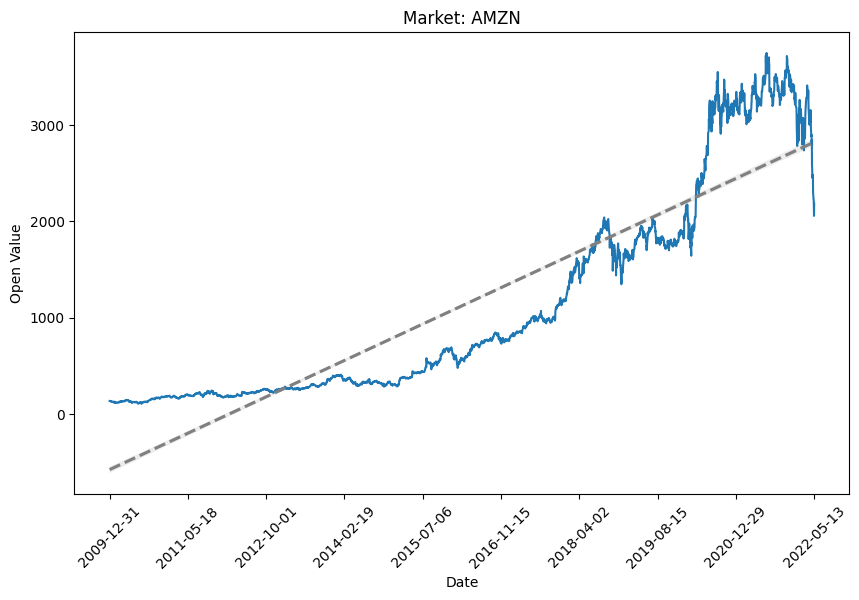

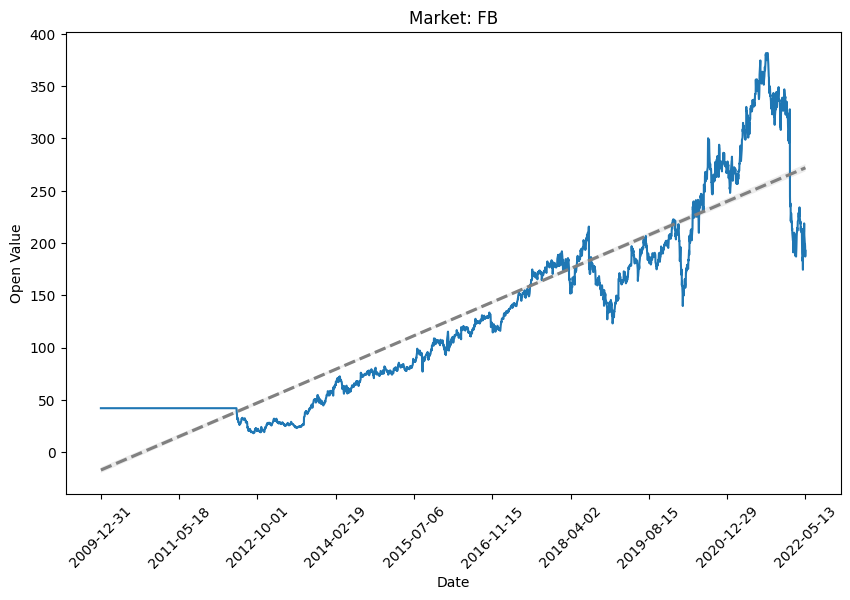

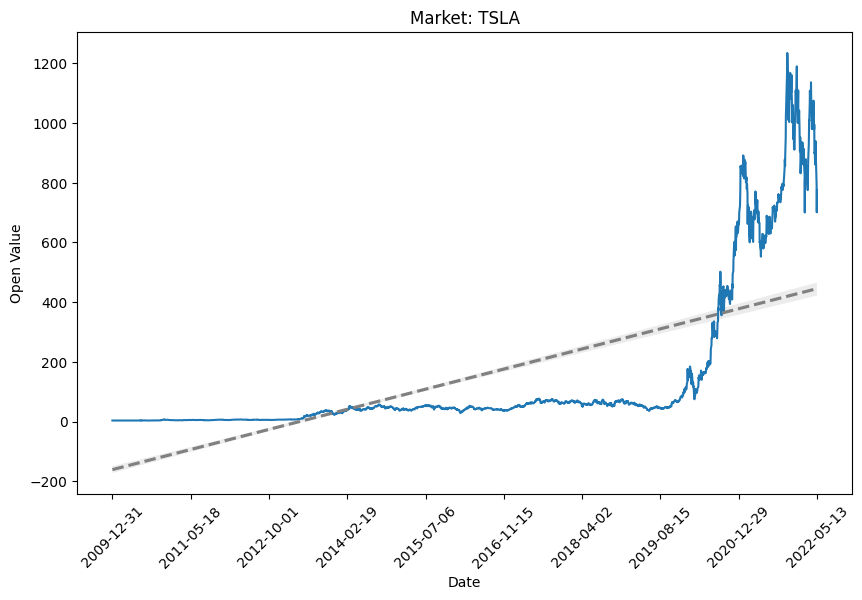

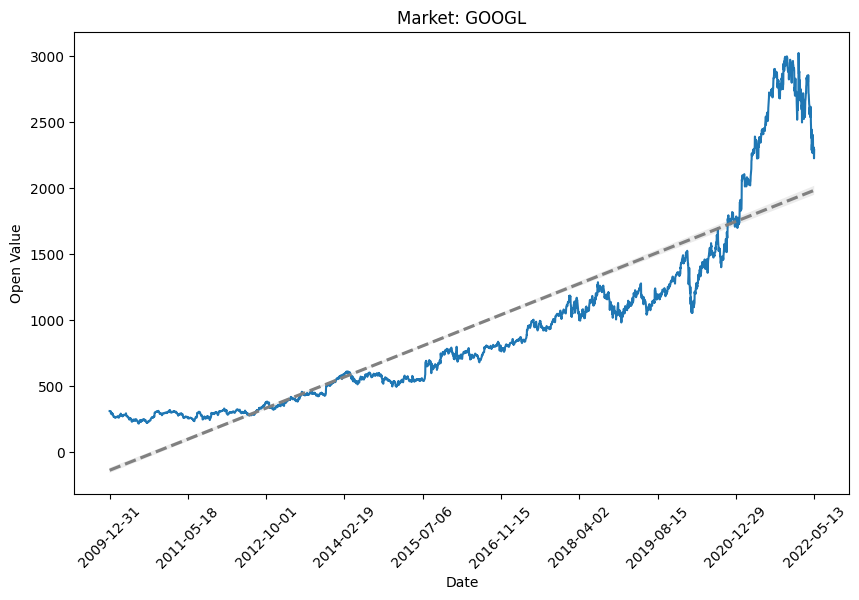

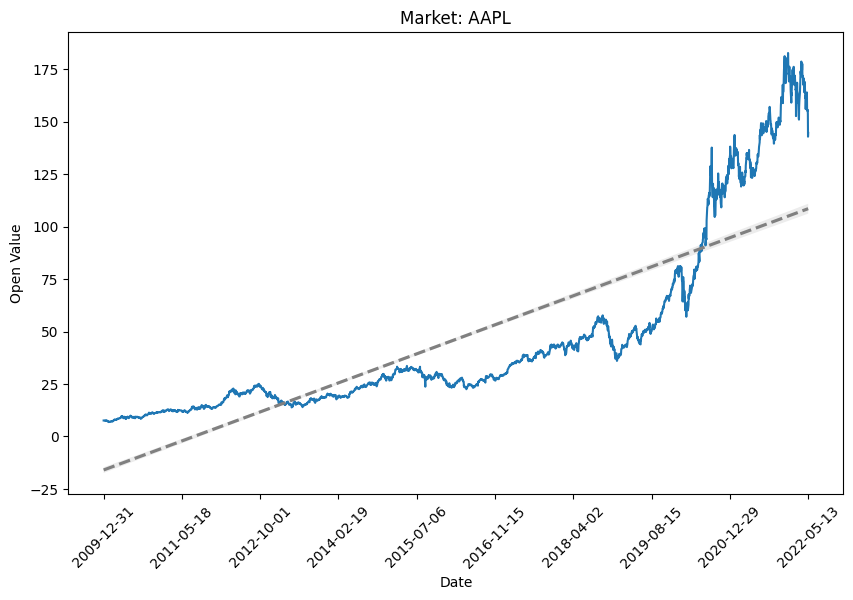

In [458]:
for symbol, market in workspace.markets.items():
    market.plot(
        figsize = (10, 6),
        regression = True,
        xticks_number = 10,
        xticks_rotation = 45
    )